In [2]:
import numpy as np
from numpy.linalg import norm
from qibo import Circuit, gates
from qibo.symbols import I, X, Y, Z
from qibo.optimizers import optimize
from qibo.quantum_info import infidelity
from qibo import set_backend

file = 0

""" Returns a classical shadow of size shadow_size of the state generated by circuit, where
each snapshot consists of an array of num_qubits 2 by 2 matrices"""
def calculate_classical_shadow(circuit, shadow_size, num_qubits):

    # Maps the Pauli measurements to the indeces 0, 1, 2 = X, Y, Z
    Pauli = [gates.X, gates.Y, gates.Z]

    # Measurement basis are chosen at random
    measurement_basis = np.random.randint(0, 3, size = (shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for i in range(shadow_size):
        # In each snapshot, we perform a measurement in a randomly chosen basis
        c = circuit.copy()
        c.add(gates.M(*range(num_qubits), basis = [Pauli[measurement_basis[i][j]] for j in range(num_qubits)]))
        outcomes[i] = c(nshots = 1).samples(binary = True)[0]
    
    # Possible states in matrix form
    states = [np.array([[1, 0],[0, 0]]), np.array([[0, 0], [0, 1]])]
    # Matrices to invert the implicit unitary operations performed when measuring in different basis
    unitaries = [gates.H(0).matrix(), gates.H(0).matrix()@gates.S(0).dagger().matrix(), gates.I(0).matrix()]
    shadow = np.empty((shadow_size, num_qubits), dtype = np.ndarray)

    # Computes the classical shadows for each snapshots
    for i in range(shadow_size):
        for j in range(num_qubits):
            state = states[int(outcomes[i][j])]
            U = unitaries[measurement_basis[i][j]]
            shadow[i][j] = 3*(U.conj().T @ state @ U) - np.eye(2)

    return shadow

"""Returns a bound on the size of a classical shadow such that the estimation of 
the observables yields a maximum error with a certain failure rate"""
def shadow_bound(observables, error = 0.01, failure_rate = 0.01, locality = 1):
    M = np.size(observables, axis = 0)
    infty_norm = max([norm(obs, ord = np.inf) for obs in observables])
    return int((4**(locality + 1))/(error**2)*np.log(2*M/failure_rate)*(infty_norm**2))

"""Creates a 2-local block for an alternating layered ansatz"""
def S_block(theta):
    c = Circuit(2)
    c.add(gates.RX(0, theta[0]))
    c.add(gates.RY(0, theta[1]))
    c.add(gates.RX(0, theta[2]))
    c.add(gates.RX(1, theta[3]))
    c.add(gates.RY(1, theta[4]))
    c.add(gates.RX(1, theta[5]))
    c.add(gates.CNOT(0, 1))
    c.add(gates.RX(0, theta[6]))
    c.add(gates.RY(0, theta[7]))
    c.add(gates.RX(0, theta[8]))
    c.add(gates.RX(1, theta[9]))
    c.add(gates.RY(1, theta[10]))
    c.add(gates.RX(1, theta[11]))
    c.add(gates.CNOT(1, 0))
    return c

"""Given a set of (num_qubits//2)*depth*12 angles, generates an alternating layered ansatz"""
def alternating_layered_ansatz(depth, num_qubits, theta, density_matrix = True):
    c = Circuit(num_qubits, density_matrix = density_matrix)
    for j in range(depth):
        for i in range(num_qubits//2):
            c.add(S_block(theta[i][j]).on_qubits((2*(i - 1) + j)%num_qubits, (2*(i - 1)+ j + 1)%num_qubits))
    return c

"""An infidelity-like 1-local cost function for the state preparation problem"""
def cost(theta, observables, reduced_shadows, num_qubits, depth, rho):

    global file

    s = 0
    c = alternating_layered_ansatz(depth, num_qubits, theta.reshape(num_qubits//2, depth, 12))

    #For maximum efficency, we exploit the locality of the observables and make use only of the necessary dimensions
    for i in range(num_qubits):
        u = c.light_cone(i)[0].unitary()
        s += (u.conj().T@observables[i]@u@reduced_shadows[i]).trace()
    a = str(abs(infidelity(c.invert()().state(), rho)))
    file.write(str(abs(1-s)) + " " + a + "\n")
    print(str(abs(1-s)) + " " + a + "\n")
    return abs(1 - s)

def infidelity_vs_shadow_size(num_qubits, depth, iterations):

    global file 

    file = open("datos/infidelity_vs_shadow_size_" + str(num_qubits) + "8.txt", 'a')

    for _ in range(iterations):

        #Generation of random alternating layered ansatz and reduced observables
        rng = np.random.default_rng()
        theta = rng.uniform(0, 2*np.pi, ((num_qubits//2), depth, 12))
        c = alternating_layered_ansatz(depth, num_qubits, theta)
        rho = c().state()
        c = alternating_layered_ansatz(depth, num_qubits, theta, False)
        A = [c.light_cone(i)[1] for i in range(num_qubits)]
        observables = [(I(A[i][i]).full_matrix(len(A[i])) + Z(A[i][i]).full_matrix(len(A[i])))/(2*num_qubits) for i in range(num_qubits)]
        x = np.round((shadow_bound(observables)**(1/100))**np.arange(1, 101))

        for size in x:
            
            #Generation of the classical shadow and reduced shadows
            shadow = calculate_classical_shadow(c, int(size), num_qubits)
            rho_shadow = 0
            for i in range(int(size)):
                rho_snapshot = [1]
                for j in range(num_qubits):
                    rho_snapshot = np.kron(rho_snapshot, shadow[i][j])
                rho_shadow += 1/size*rho_snapshot
            file.write(str(size) + " " + str(abs(infidelity(rho_shadow, rho))) + "\n")
            print(str(size) + " " + str(abs(infidelity(rho_shadow, rho))) + "\n")

        file.write("---\n")
        print("---\n")


    file.close()

def infidelity_vs_iterations(num_qubits, depth, iterations):
    
    global file 

    file = open("datos/infidelity_vs_iterations_" + str(num_qubits) + ".txt", 'a')
        

    for _ in range(iterations):

        #Generation of random alternating layered ansatz and reduced observables
        rng = np.random.default_rng()
        theta = rng.uniform(0, 2*np.pi, ((num_qubits//2), depth, 12))
        c = alternating_layered_ansatz(depth, num_qubits, theta)
        A = [c.light_cone(i)[1] for i in range(num_qubits)]
        observables = [(I(A[i][i]).full_matrix(len(A[i])) + Z(A[i][i]).full_matrix(len(A[i])))/(2*num_qubits) for i in range(num_qubits)]
        rho = c().state()

        #Generation of the classical shadow and reduced shadows
        shadow = calculate_classical_shadow(c, shadow_bound(observables), num_qubits)
        reduced_shadows = np.zeros(num_qubits, dtype = np.ndarray)
        T = np.size(shadow, axis = 0)
        for i in range(num_qubits):
            for j in range(T):
                hat_rho = [1/T]
                for k in list(A[i]):
                    hat_rho = np.kron(hat_rho, shadow[j][k])
                reduced_shadows[i] = reduced_shadows[i] + hat_rho

        #Optimization procedure
        initial_theta = np.zeros((num_qubits//2)*depth*12)
        best, params, extra = optimize(cost, initial_theta, args = (observables, reduced_shadows, num_qubits, depth, rho), method = 'L-BFGS-B', options = {'maxiter': 100})
        a = infidelity(alternating_layered_ansatz(depth, num_qubits, params.reshape(num_qubits//2, depth, 12)).invert()().state(), rho)
        file.write(str(best) + " " + str(abs(a)) + "\n")
        print(str(best) + " " + str(abs(a)) + "\n")
        file.write("---\n")
        print("---\n")
        file.close()
        file = open("datos/infidelity_vs_iterations_" + str(num_qubits) + ".txt", 'a')

    file.close()

infidelity_vs_iterations(2, 4, 1)

KeyboardInterrupt: 

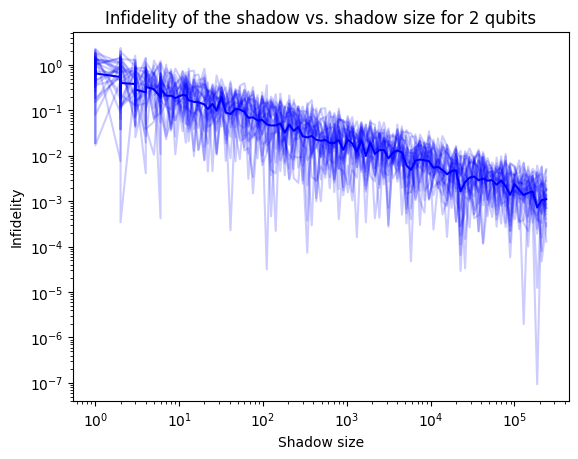

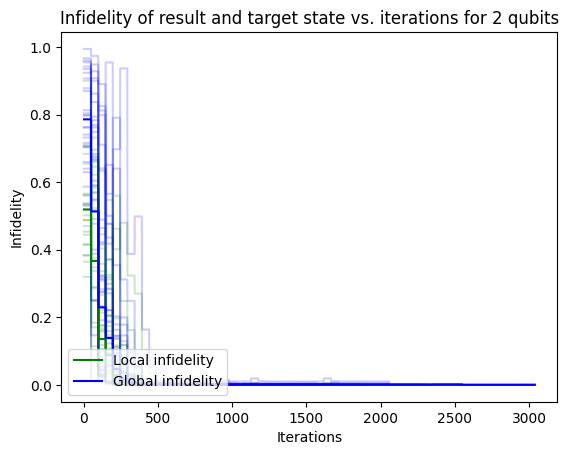

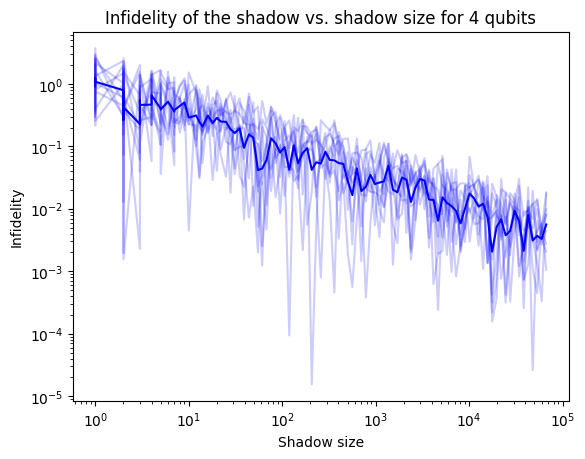

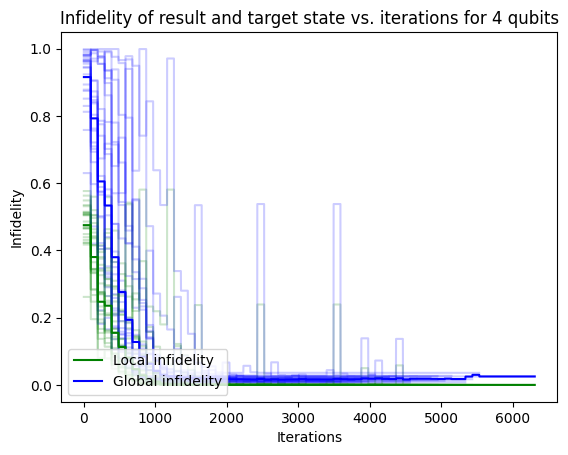

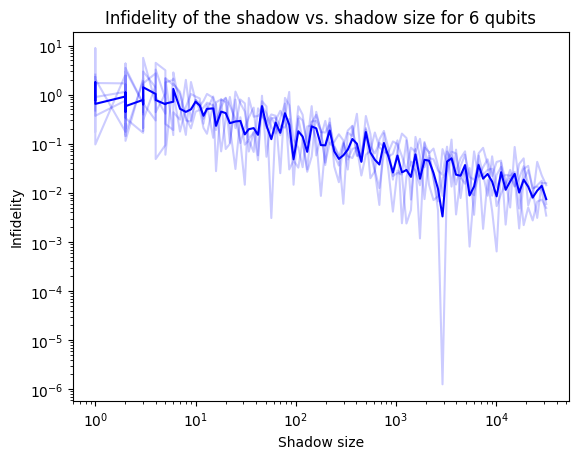

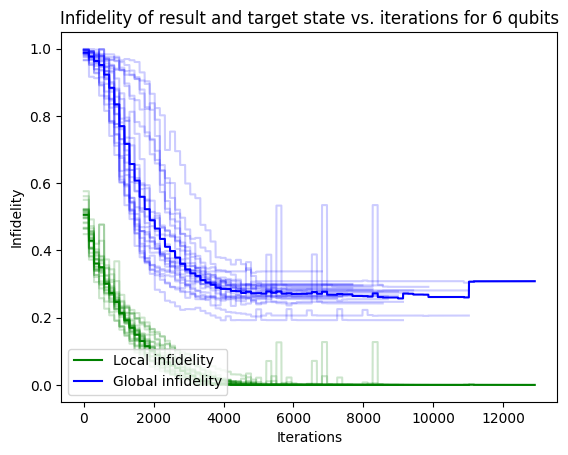

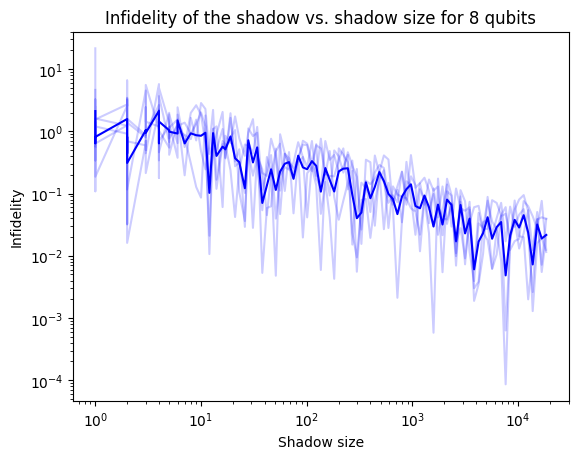

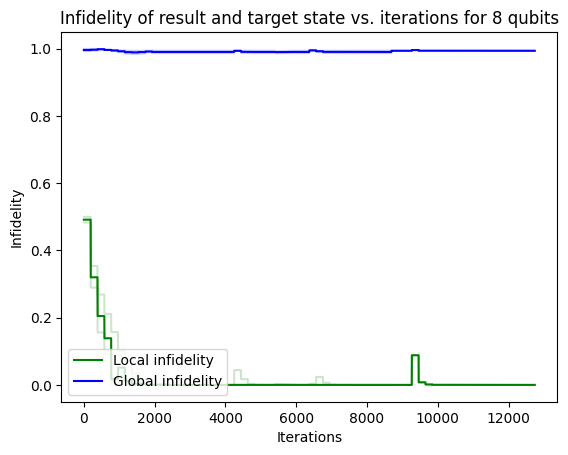

In [87]:
import matplotlib.pyplot as plt
import numpy as np


def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


for n in [2, 4, 6, 8]:

    first = True
    list_x = []
    list_y = []
    x = np.empty(0)
    y = np.empty(0)
    file = open("datos/infidelity_vs_shadow_size_" + str(n) + ".txt")
    fig = plt.figure()
    r = file.readline(1)
    while(r != "-" and r != ''):

        x_str = ""
        while(r != " "):
            x_str = x_str + r
            r = file.readline(1)

        x = np.append(x, float(x_str))
        y = np.append(y, float(file.readline()))
        r = file.readline(1)

        if(r == '-'):
            r = file.readline()
            r = file.readline(1)
            plt.plot(x, y, 'b', alpha = 0.2)
            list_x.append(x)
            list_y.append(np.log(y))
            x = []
            y = []
    
    y_avg = np.exp(np.average(list_y, axis = 0))
    plt.plot(list_x[0], y_avg, 'b', alpha = 1)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("Infidelity")
    plt.xlabel("Shadow size")
    plt.title("Infidelity of the shadow vs. shadow size for " + str(n) + " qubits")
    plt.show()

    first = True
    list_x = []
    list_y = []
    x = []
    y = []
    file = open("datos/infidelity_vs_iterations_" + str(n) + ".txt")
    fig2 = plt.figure()
    r = file.readline(1)
    while(r != "-" and r != ''):
        
        x_str = ""
        while(r != " "):
            x_str = x_str + r
            r = file.readline(1)
        
        x = np.append(x, float(x_str))
        y = np.append(y, float(file.readline()))
        r = file.readline(1)
        if(r == '-'):
            r = file.readline()
            r = file.readline(1)
            plt.plot(x, 'g', alpha = 0.2)
            plt.plot(y, 'b', alpha = 0.2)
            list_x.append(np.log(x))
            list_y.append(np.log(y))
            x = []
            y = []

    y, error = tolerant_mean(list_x)
    plt.plot(np.arange(len(y))+1, np.exp(y), 'g', alpha = 1, label = "Local infidelity")  
    y, error = tolerant_mean(list_y)
    plt.plot(np.arange(len(y))+1, np.exp(y), 'b', alpha = 1, label = "Global infidelity")  


    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Infidelity")
    plt.title("Infidelity of result and target state vs. iterations for " + str(n) + " qubits")
    legend = plt.legend(loc='lower left')
    plt.show()


